# Adaptive gains
This script will see how the adaptive algorithm out-preforms the passive algorithm.

It does this by seeing how many rankings are considered the funniest ranking. For each caption we have a mean and a standard deviation. If the first rated caption has mean $\mu_1$ and std.dev. of $\sigma_1$, we want how many captions $i$ have $\mu_i + \sigma_i > \mu_1 - \sigma_1$.

### Metrics
* Number of "top captions"
* Mean/median rank of top $n$ captions (top captions from the end of the contest)

## Obtaining the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import utils

## Finding the mean and number of possible top captions 
Another implementation can be found in `/summary-stats/summary-stats-v2.py`.

In [2]:
def find_top_captions(df):
    i_top_mean = np.argmax(df['score'].values)#idxmax(skipna=True)
    top_caption = df.iloc[i_top_mean]
    min_rating = top_caption['score'] - top_caption['precision']
    df['upper bound'] = df['score'] + df['precision']
    
    return (df['upper bound'] > min_rating).sum(), top_caption['score'], top_caption['precision']

In [3]:
def iteration_stats(ratings, top_captions=None):
    """
    Parameters
    ----------
    top_captions
        target_ids considered "top" (i.e., top 10 at the end of the contest)
    """
    ratings = utils.calculate_stats(ratings)
    funny_captions, top_mean, top_prec = find_top_captions(ratings) 
    ret = {'funny_captions': funny_captions}
    
    if top_captions is not None:
        ranks = []
        for target_id in top_captions:
            rank = ratings[ratings['target_id'] == target_id]['rank'].values
            assert 1 <= len(rank) <= 2
            ranks += [r for r in rank]
        ranks = np.array(ranks)
            
        ret.update({'median_rank_top': np.median(ranks),
                    'mean_rank_top': np.mean(ranks),
                    'n_top': len(top_captions)})

    return ret

## Initializing responses
These are the variables we will count the responses in

## Replaying one contest 

In [4]:
import sys

def replay_contest(df, verbose=True, top_captions=None, **kwargs):
    """
    Replay the contest. Find and record stats at certain intervals
    
    Parameters
    ----------
    df : pd.DataFrame
        Responses to the contest (not necessarily sorted) 
        
    Returns
    -------
    performance : pd.DataFrame
       includes fields of algorithm, responses, (possible) top captions 
       
    """
    df = df.sort_values(by='timestamp_query_generated')
    n_captions = len(df['target_id'].unique())
    ratings = {alg: utils.init_summary(df) for alg in df['alg_label'].unique()}
    performance = [] 
    kwargs = {}
    
    j = 0
    for _, response in df.iterrows():
        if j > 2:
            assert last_response['timestamp_query_generated'] <= response['timestamp_query_generated']
            
        alg_label = response['alg_label']
        ratings[alg_label] = utils.add_response(ratings[alg_label], response)
        
        n_responses = ratings[alg_label]['count'].sum()
        if n_responses % n_captions == 0 and n_responses >= n_captions:
            if top_captions:
                kwargs = {'top_captions': top_captions[alg_label]}
            stats = iteration_stats(ratings[alg_label], **kwargs)
            datum = {'responses': n_responses,
                     'algorithm': alg_label,
                     'n_captions': n_captions}
            datum.update(stats)
            if verbose:
                print('Number of epochs = {}, total_fraction = {}'.format(j / n_captions, j / len(df)))
            performance += [datum]
            
        last_response = response
        j += 1
    performance = pd.DataFrame(performance)
    return performance, ratings

In [5]:
contest = '559-active'
responses = utils.read_responses('{}-responses.csv.zip'.format(contest))

In [6]:
n_top_captions = 20
top = {}
for alg in responses['alg_label'].unique():
    df = utils.summary_from_responses(responses, alg=alg)
    target_ids = df[df['rank'] <= n_top_captions]['target_id']
    assert len(target_ids.values) <= n_top_captions
    top[alg] = target_ids.values.tolist()
print(top)
print('...done loading data')
    
final = utils.read_summary('559_summary_{}.csv'.format(alg))
final = utils.add_target_ids(final, responses)
iteration_stats(final, top_captions=top[alg])

{'LilUCB': [1440, 2908, 3360, 3365, 2666, 4597, 4434, 2106, 4419, 1004, 3230, 1330, 4146, 4231, 4818, 832, 3425, 226, 2904, 2503], 'KLUCB': [3855, 236, 2994, 4920, 3406, 4988, 1880, 140, 1611, 683, 2976, 603, 4986, 4910, 1707, 2478, 2128, 2270, 4648, 2076]}
...done loading data


{'funny_captions': 3,
 'mean_rank_top': 2438.7272727272725,
 'median_rank_top': 2288.0,
 'n_top': 20}

In [7]:
kwargs = {'top_captions': top}
stats, summary = replay_contest(responses, **kwargs)
stats['contest'] = contest

Number of epochs = 1.9702713487629688, total_fraction = 0.01975537346158155
Number of epochs = 2.031923383878691, total_fraction = 0.0203735416033161
Number of epochs = 3.9694732641660018, total_fraction = 0.0398008258246243
Number of epochs = 4.02952913008779, total_fraction = 0.04040298961317478
Number of epochs = 5.9351556264964085, total_fraction = 0.05951018677080166
Number of epochs = 6.056464485235435, total_fraction = 0.06072651761279068
Number of epochs = 7.928371907422187, total_fraction = 0.07949562280940416
Number of epochs = 8.074820430965682, total_fraction = 0.08096402221404222
Number of epochs = 9.929169992019155, total_fraction = 0.09955707952563098
Number of epochs = 10.071827613727056, total_fraction = 0.10098746859145688
Number of epochs = 11.90582601755786, total_fraction = 0.11937647039994878
Number of epochs = 12.091580207501995, total_fraction = 0.12123897700174448
Number of epochs = 13.91001596169194, total_fraction = 0.13947193636669175
Number of epochs = 14.0

In [8]:
stats.head()

,algorithm,funny_captions,mean_rank_top,median_rank_top,n_captions,n_top,responses,contest
0,KLUCB,0,2569.00,2350.0,5012,20,5012.0,559-active
1,LilUCB,0,3278.50,3445.5,5012,20,5012.0,559-active
2,KLUCB,5012,2497.20,2217.0,5012,20,10024.0,559-active
3,LilUCB,5012,2921.35,3095.5,5012,20,10024.0,559-active
4,KLUCB,1776,2241.15,2579.5,5012,20,15036.0,559-active


## Visualization
This means that LilUCB saw ~10 captions that could be the funniest, and RoundRobin saw ~50 captions that could be the funniest. 

This visualization tries to normalize for different number of captions received in each contest by

* plotting for "epochs", or `epochs = questions_received_for_alg / total_captions`. 
* plotting the score as the percentage of "winning" captions.
* "winning captions" is defined to be number of captions that fall who has a mean within one std.dev of top caption. 

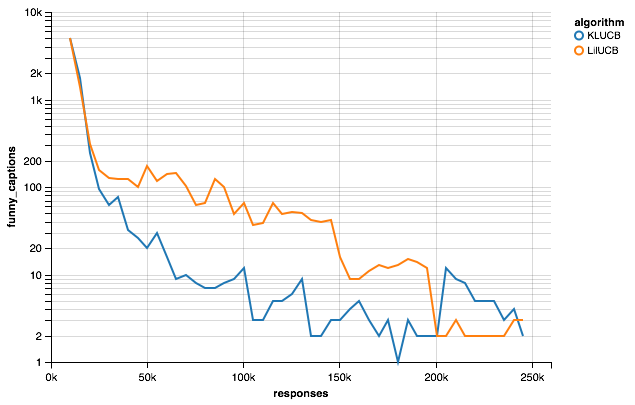

In [9]:
from altair import Chart, Y, Scale, X

Chart(stats).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('funny_captions', scale=Scale(type='log')),
    color='algorithm')

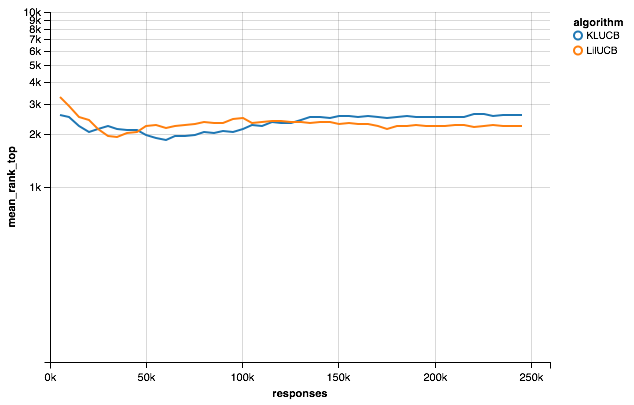

In [10]:
Chart(stats).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('mean_rank_top', scale=Scale(type='log')),
    color='algorithm')

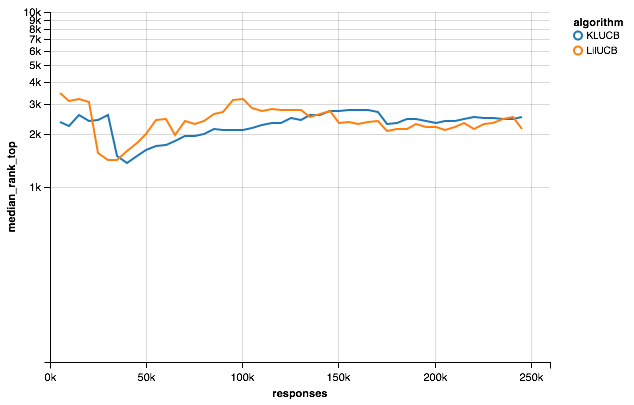

In [11]:
Chart(stats).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('median_rank_top', scale=Scale(type='log')),
    color='algorithm')

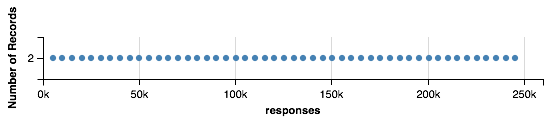

In [12]:
Chart(stats).mark_circle().encode(
    x='responses', y=Y('count(contest)', sort='descending')
)

In [13]:
alg = 'LilUCB'
s = summary[alg]
s = s.sort_values(by='score', ascending=False)
s.head()

,count,funny,precision,score,somewhat_funny,target_id,unfunny
1734,205.0,66.0,0.062872,1.840796,39.0,387,100.0
4967,189.0,48.0,0.059506,1.813830,57.0,445,84.0
1867,176.0,41.0,0.060761,1.787356,56.0,1082,79.0
2357,142.0,31.0,0.068842,1.705036,38.0,3120,73.0
738,126.0,22.0,0.068599,1.661290,38.0,1392,66.0


In [14]:
t = utils.read_summary('559_summary_{}.csv'.format(alg))
t = utils.add_target_ids(t, responses)
t = t.sort_values(by='score', ascending=False)
t.head()

,rank,caption,score,precision,count,unfunny,somewhat_funny,funny,target_id
0,1,Poor guy. Thought he signed up for pilates.,1.834146,0.061924,205.0,100.0,39.0,66.0,387
1,2,We may regret this. He looked delicious.,1.809524,0.059346,189.0,84.0,57.0,48.0,445
2,3,I can't believe my eye!,1.784091,0.060247,176.0,79.0,56.0,41.0,1082
3,4,"Now, that's what I call execution.",1.704225,0.067630,142.0,73.0,38.0,31.0,3120
4,5,He's taking it better than I expected.,1.650794,0.073305,126.0,72.0,26.0,28.0,3946


In [15]:
import numpy as np
responses = utils.read_responses('535-responses.csv.zip')
summary = utils.init_summary(responses)

actual = utils.read_summary('535_summary_LilUCB.csv')
actual = utils.add_target_ids(actual, responses)
actual = actual.sort_values(by='target_id')

i = 0
n = len(responses)
n_captions = len(responses['target_id'].unique())
for _, response in responses.iterrows():
    summary = utils.add_response(summary, response)
    if i % n_captions == 0:
        print(i / len(responses))
    i += 1
summary = summary.sort_values(by='target_id', ascending=True)
summary = utils.calculate_stats(summary)
for key, value in {'count': 18, 'score': 0.18}.items():
    diff = np.abs(actual[key].values - summary[key].values)
    assert diff.max() <= value

0.0
0.01281383718049391
0.02562767436098782
0.038441511541481725
0.05125534872197564
0.06406918590246954
0.07688302308296345
0.08969686026345737
0.10251069744395128
0.11532453462444518
0.1281383718049391
0.140952208985433
0.1537660461659269
0.16657988334642082
0.17939372052691474
0.19220755770740863
0.20502139488790255
0.21783523206839644
0.23064906924889036
0.24346290642938428
0.2562767436098782
0.26909058079037207
0.281904417970866
0.2947182551513599
0.3075320923318538
0.32034592951234775
0.33315976669284164
0.34597360387333553
0.3587874410538295
0.3716012782343234
0.38441511541481727
0.39722895259531116
0.4100427897758051
0.422856626956299
0.4356704641367929
0.44848430131728684
0.46129813849778073
0.4741119756782746
0.48692581285876857
0.49973965003926246
0.5125534872197564
0.5253673244002502
0.5381811615807441
0.5509949987612381
0.563808835941732
0.5766226731222259
0.5894365103027198
0.6022503474832137
0.6150641846637076
0.6278780218442015
0.6406918590246955
0.6535056962051894
0.66

AssertionError: 